In [1180]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import scipy
import math
import bitarray
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,4)

In [1181]:
#message to transmit
ba = bitarray.bitarray()
text = 'Bonjour, je suis le message a transmettre'
ba.frombytes(text.encode())
data = np.array(ba.tolist()).astype(int)
print(text)

Bonjour, je suis le message a transmettre


# Encoder

In [1182]:
Fs = 22050 #sampling freq. in hz
Fc = 1050 #frequency of carrier signal
baud_rate = Fc #need to be less than Fc
modulation_freq = 7500 #modulation frequency in hertz
data_size = len(data)
T = (data_size/baud_rate) #length in sec
sample_per_bit = int(Fs/baud_rate)
print(T)
print(sample_per_bit)

0.31238095238095237
21


In [1183]:
#transform 0 to -1 in data 
data_tx = np.ones(len(data))
data_tx[data==0] = -1
print(data_tx)

[-1.  1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.
  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1.
  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.
  1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.
  1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.
 -1.  1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.
  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1.
 -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.
  1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1.
 -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1. -1. -1.
 -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.
 -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1. -1.
  1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1

In [1184]:
#upsample data :
data_tx = np.repeat(data_tx,sample_per_bit)
#modulate carrier with data :
tx_signal = np.sin(np.arange(0, len(data_tx)) * 2 *np.pi * (Fc/Fs)) * data_tx 

<StemContainer object of 3 artists>

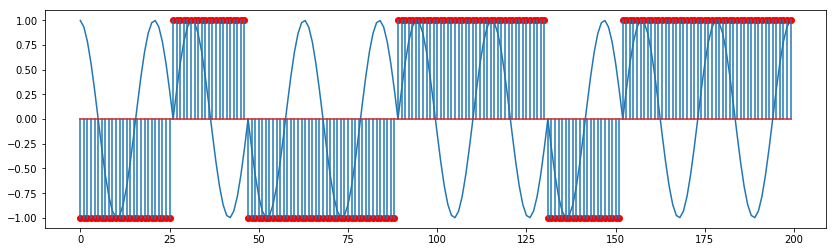

In [1185]:
#plot first samples of tx_signal
plt.plot(tx_signal[100:300])
plt.stem(data_tx[100:300],markerfmt = 'ro')

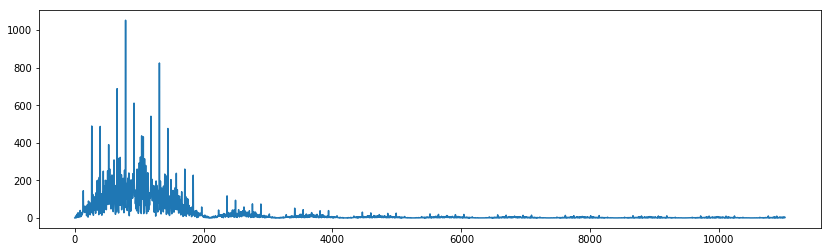

In [1186]:
tx_fft = np.abs(np.fft.fft(tx_signal))
N = int(len(tx_fft)/2)
plt.plot(np.linspace(0,1,N) * (Fs/2), tx_fft[0:N]);

In [1187]:
#modulate signal
tx_signal_modulated = tx_signal * np.cos(np.arange(0,len(tx_signal)) * 2 * np.pi * (modulation_freq/Fs))

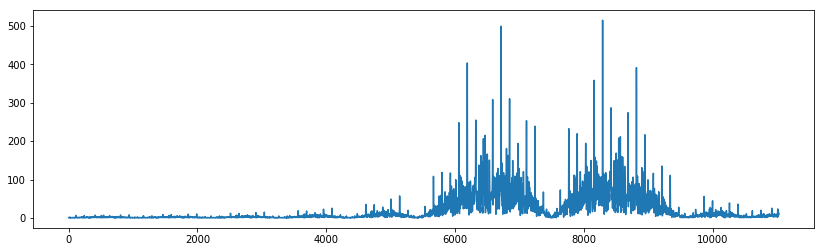

In [1188]:
tx_modulated_fft = np.abs(np.fft.fft(tx_signal_modulated))
N = int(len(tx_fft)/2)
plt.plot(np.linspace(0,1,N) * (Fs/2), tx_modulated_fft[0:N]);

# Channel

In [1189]:
# channel
#frequency cut
erase_indice = 1 #band to erase 
channel_signal = tx_signal_modulated
channel_signal_fft = scipy.fftpack.fft(channel_signal)
N = len(channel_signal_fft)
erase_low_freq = (erase_indice * 2000) * N  / (Fs)
erase_high_freq = erase_low_freq + (2000 * N / (Fs))
channel_signal_fft[int(erase_low_freq):int(erase_high_freq)] = 0
channel_signal = scipy.fftpack.ifft(channel_signal_fft)

#noise
noise = noise = np.random.normal(0,0.05,len(tx_signal_modulated))
rx_signal = channel_signal + noise

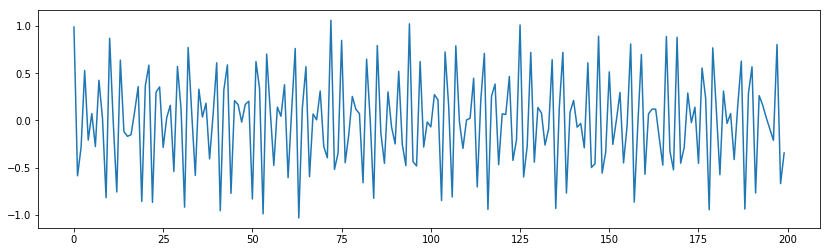

In [1190]:
plt.plot(rx_signal[100:300])

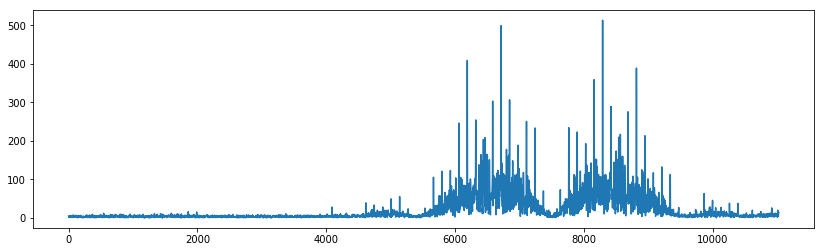

In [1191]:
N = int(len(rx_signal)/2)
rx_fft = np.abs(np.fft.fft(rx_signal))
plt.plot(np.linspace(0,1,N) * (Fs/2), rx_fft[0:N]);

# Decoder

In [1192]:
#lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sp.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.filtfilt(b, a, data)
    return y

In [1193]:
# demodulate signal
rx_signal_demod =  rx_signal * np.cos(2 * np.pi * (modulation_freq/Fs) * np.arange(0,len(rx_signal)))
#filter signal
rx_signal_demod = butter_lowpass_filter(rx_signal_demod,Fc + 100, Fs, 10)

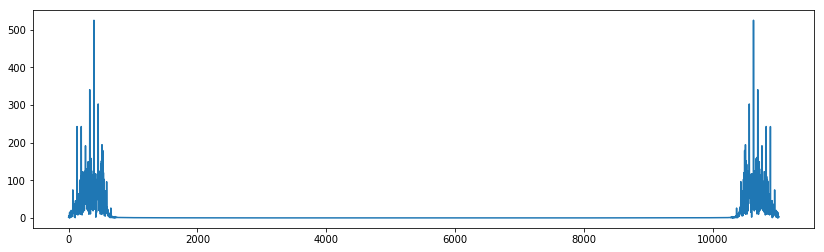

In [1194]:
rx_demod_fft = np.abs(np.fft.fft(rx_signal_demod))
N = int(len(rx_demod_fft))
plt.plot(np.linspace(0,1,N) * (Fs/2), rx_demod_fft[0:N]);

<StemContainer object of 3 artists>

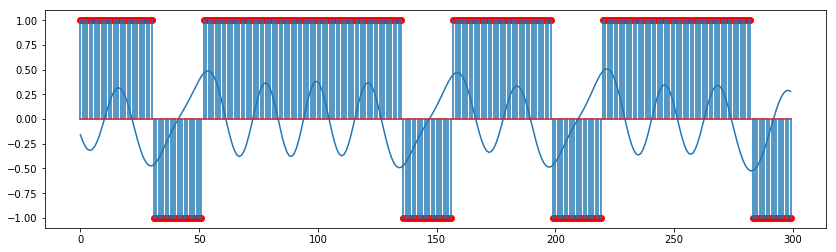

In [1195]:
plt.plot(rx_signal_demod[200:500])
plt.stem(data_tx[200:500],markerfmt = 'ro')

In [1196]:
#computer the inner product with the base signal to determine bit sent
pulse = np.sin(np.arange(0, sample_per_bit) * 2 *np.pi * sample_per_bit)
#signal_correlated = np.convolve(rx_signal_demod,pulse)
signal_correlated = sp.correlate(rx_signal_demod,pulse)

In [1197]:
print(data[0:20])
matched_filter_output = signal_correlated[np.arange(1,data_size + 1) * sample_per_bit]
received_data = np.zeros(data_size, int)
received_data [matched_filter_output>0] = 1
print(received_data[0:20])

[0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0]
[0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0]


In [1198]:
#compute number of errors
err = abs(received_data - data).sum()
print(err)

0


In [1199]:
#decode data
message = np.packbits(received_data)
message = str(message.tobytes(),"utf-8","ignore")
message

'Bonjour, je suis le message a transmettre'

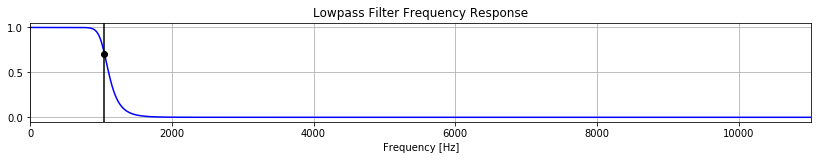

In [1200]:
# Filter requirements.
order = 10
fs = Fs   # sample rate, Hz
cutoff = Fc  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = sp.freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()